# Lab: Image classification with MLPs

------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

-----------------------------------------------------

In this lab, you will implement an image classifier using MLPs. We will use the MNIST dataset, which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

PRÁCTICA 2. PARTE 1

DIEGO COLLADO MARTÍN - NIA: 100405606

DIEGO LÓPEZ LÓPEZ - NIA: 100507210


In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png", width=400, height=200)

# Cargamos el dataset que consta de imágenes de 28x28 píxeles sin color con números del 0 al 9

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download MNIST with `torchvision`

First up, we need to get our dataset. This is provided through the `torchvision` package. The [torchvision package](https://pytorch.org/docs/stable/torchvision/index.html) consists of popular datasets, model architectures, and common image transformations for computer vision.


The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [4]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to **shuffle the dataset every time we start going through the data loader again**. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, **1 color channel**, and 28x28 images.

In [6]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

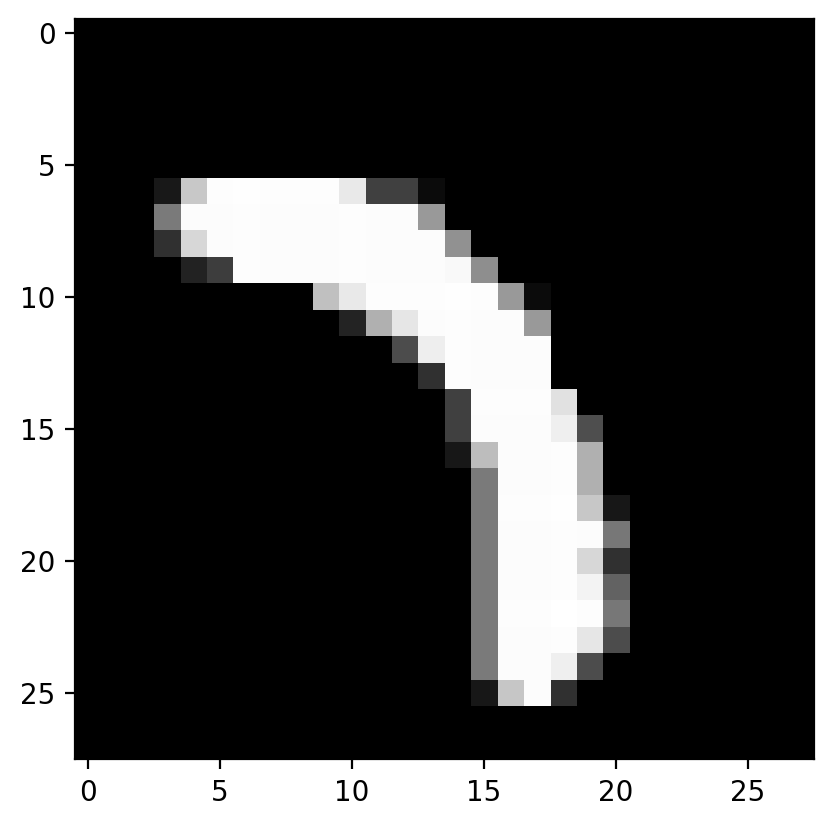

In [7]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Train a multi-class Logistic Regressor

Our first goal is to train a multi-class logistic regressor to evaluate how good it can do in both the training and the test sets. 

The following code is **almost identical** to the one you used for Lab 1 except for two small details:

- We are training a LR classifier with 10 different outputs that implements a **softmax** non-linear function (instead of a binary LR with a sigmoid). 

- We are using the MNIST database loaded above.

We first define the Multi-class Logistic Regressor class

> **Exercise**: Complete the following code

In [8]:
class Multi_LR(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output = nn.Linear(dimx,nlabels)
    
         
        self.logsoftmax = nn.LogSoftmax(dim=1)   # NEW w.r.t Lab 1. dim is the dimension along which 
                                                 #Softmax will be computed (so every slice along dim will sum to 1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        #YOUR CODE HERE        
        x = self.output(x) # Aplicamos a cada imagen la operacion Linear
        x = self.logsoftmax(x) # Pasamos los valores resultantes por la logsoftmax para clasificar cada una
        return x

Note that we use `nn.LogSoftmax` instead of `nn.Softmax()`. In many cases, softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.  The cross entropy loss is obtained by combining `nn.LogSoftmax` with the negative loss likelihood loss `nn.NLLLoss()`.

Alternatively, we can use [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). **This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.**

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*.


Now we implement an extension to the class above (which inheritates from `Multi_LR`) that includes a training method.  One thing, note that MNIST images are of dimension $28\times28=784$. To feed this image as the input to a `nn.Linear` layer, it has to be converted to a $784\times 1$ input tensor. 

> **Exercise**: Complete the following code

In [9]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add. 
'''
class Multi_LR_extended(Multi_LR):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Seleccionamos el optimizador (Adam en este caso)
        
        self.epochs = epochs # Número de veces que recorremos todos los batch
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] # Lista para guardar la evolución de las pérdidas a lo largo de las épocas
        
    def train(self,trainloader): # Función para entrenar
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):   # Recorremos todo el data set las mismas veces que épocas indiquemos
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:  # En cada iteración cogemos las 64 imágenes de un batch con sus etiquetas
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1)) # Introducimos al forward 64 vectores donde en cada uno tenemos 784 valores correspondientes a cada píxel de la imagen

                #Your code here (multiple lines)

                loss = self.criterion(out, labels) # Estudiamos las pérdidas teniendo en cuenta las etiquetas reales y las predecidas

                running_loss += loss.item() # Añadimos las pérdidas al running_loss
                
                loss.backward() # Estudiamos los gradientes según las pérdidas
                
                self.optim.step() # Según los gradientes evaluados, damos un paso en la optimización
                
                
                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))


Ok that was easy, wasn't it? Lets now train the multi-class LR and evaluate the performance in both the training and the test sets.


In [10]:
my_LR = Multi_LR_extended(dimx=784,nlabels=10,epochs=5,lr=1e-3)

my_LR.train(trainloader)


Training loss after 0 epochs: 0.466160
Training loss after 1 epochs: 0.325652
Training loss after 2 epochs: 0.310701
Training loss after 3 epochs: 0.299676
Training loss after 4 epochs: 0.295062


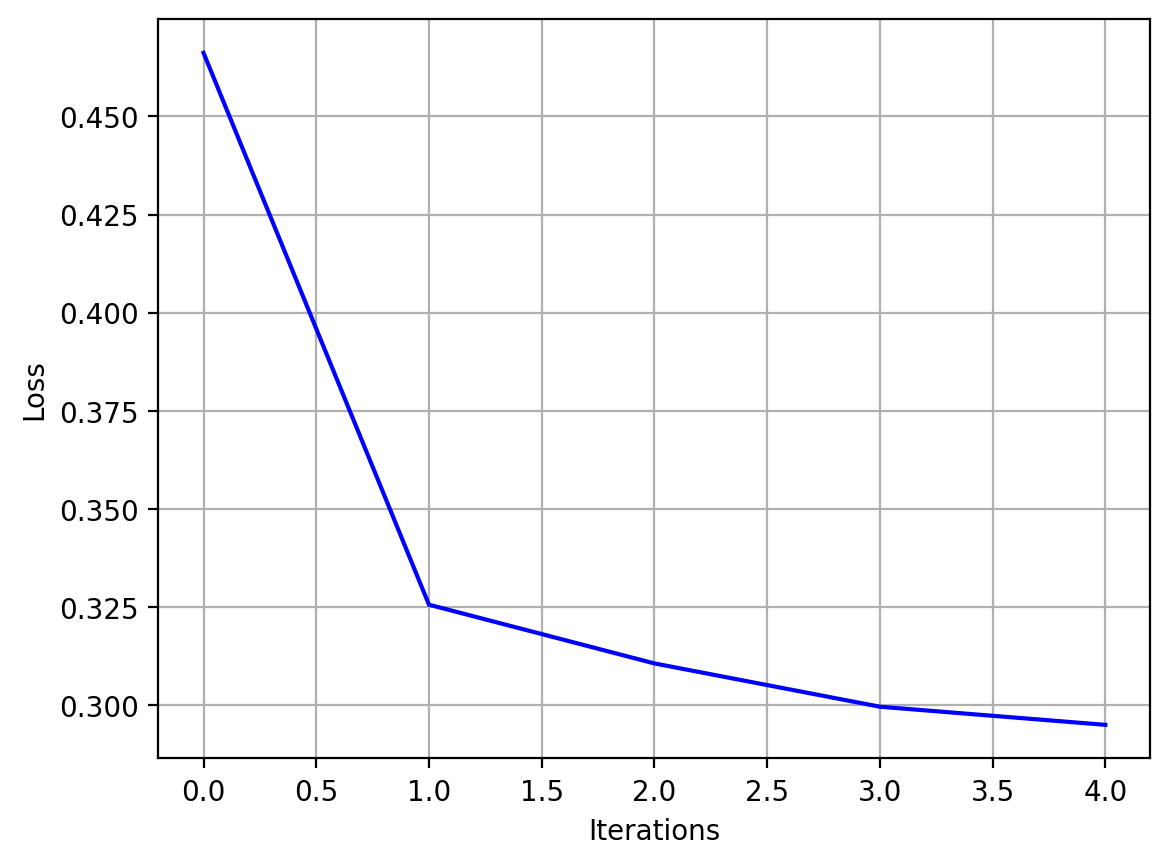

In [11]:
plt.plot(my_LR.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

To evaluate the performance across the entire test dataset, we will implement a for loop using `testloader` and compute errors per mini-batch. The following code will do the work:

In [12]:
loss = 0
accuracy = 0

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():

    for images,labels in testloader:
        
        logprobs = my_LR.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
        top_p, top_class = logprobs.topk(1, dim=1)
        equals = (top_class == labels.view(images.shape[0], 1))
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    

print("Test Accuracy %f" %(accuracy/len(testloader)))

Test Accuracy 0.918690


With the probabilities, we can get the most likely class using the `probs.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `probs.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

The line 
```python
(top_class == labels.view(images.shape[0], 1))
```
returns a boolean vector of `True/False` values, indicanting whether `top_class` is equal to `labels` at every position. Finally, with the line

```python
equals.type(torch.FloatTensor)
```
we transform it to real a vector in which `True --> 1.0` and `False --> 0.0`, where we can compute the mean using `torch.mean()`.

> **Excercise** Modify the code of the `Multi_LR_extended` class so it incorporates a method to evaluate the performance in either the train set or the test set (Use a single method with the proper inputs!). Compute the train/test accuracy using such a method.

In [17]:
#YOUR CODE HERE     

class Multi_LR_extended(Multi_LR):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
        
    def accuracy_study(self,loader): # Definimos un nuevo modelo que nos de el accuracy del conjunto que le introduzcamos
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in loader:
        
                logprobs = my_LR.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        

        return ((accuracy/len(loader)))

In [15]:
#YOUR CODE HERE    
my_LR = Multi_LR_extended(dimx=784,nlabels=10,epochs=5,lr=1e-3)

my_LR.train(trainloader)

accuracy_train = my_LR.accuracy_study(trainloader)
accuracy_test = my_LR.accuracy_study(testloader)

print('El acurracy en el set de entrenamiento es: ' + str(accuracy_train))
print('El acurracy en el set de teste es: ' + str(accuracy_test))

Training loss after 0 epochs: 0.472869
Training loss after 1 epochs: 0.328470
Training loss after 2 epochs: 0.308993
Training loss after 3 epochs: 0.301210
Training loss after 4 epochs: 0.294794
El acurracy en el set de entrenamiento es: 0.9213586
El acurracy en el set de teste es: 0.91988456


Observe that both values are indeed similar, indicating that the model is not overfitting.  

Let's check the values for the weight matrix. For a simpler visualization, we will plot the histogram of all the values in the weight matrix.

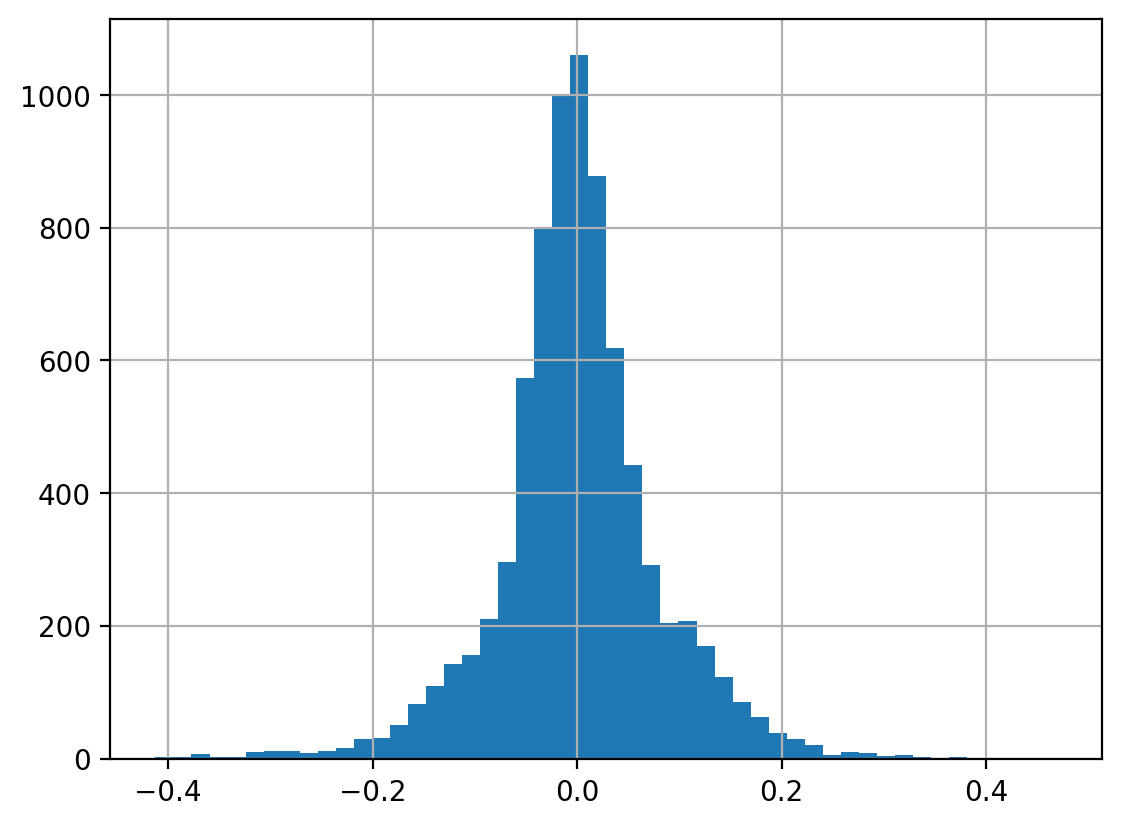

In [19]:
plt.hist(my_LR.output.weight.detach().numpy().reshape([-1,]),50) # Modify my_LR by the name of the object you defined above
plt.grid()

Podemos ver que la gran mayoría de pesos tienen un valor entorno a 0. Esto se debe a que la gran mayoría de píxeles en la imagen son blancos, no aportan información, por lo que se ponderan con valores cercanos al cero.

> **Exercise**: Plot the histogram of the gradients of the loss function w.r.t. every parameter in the model:

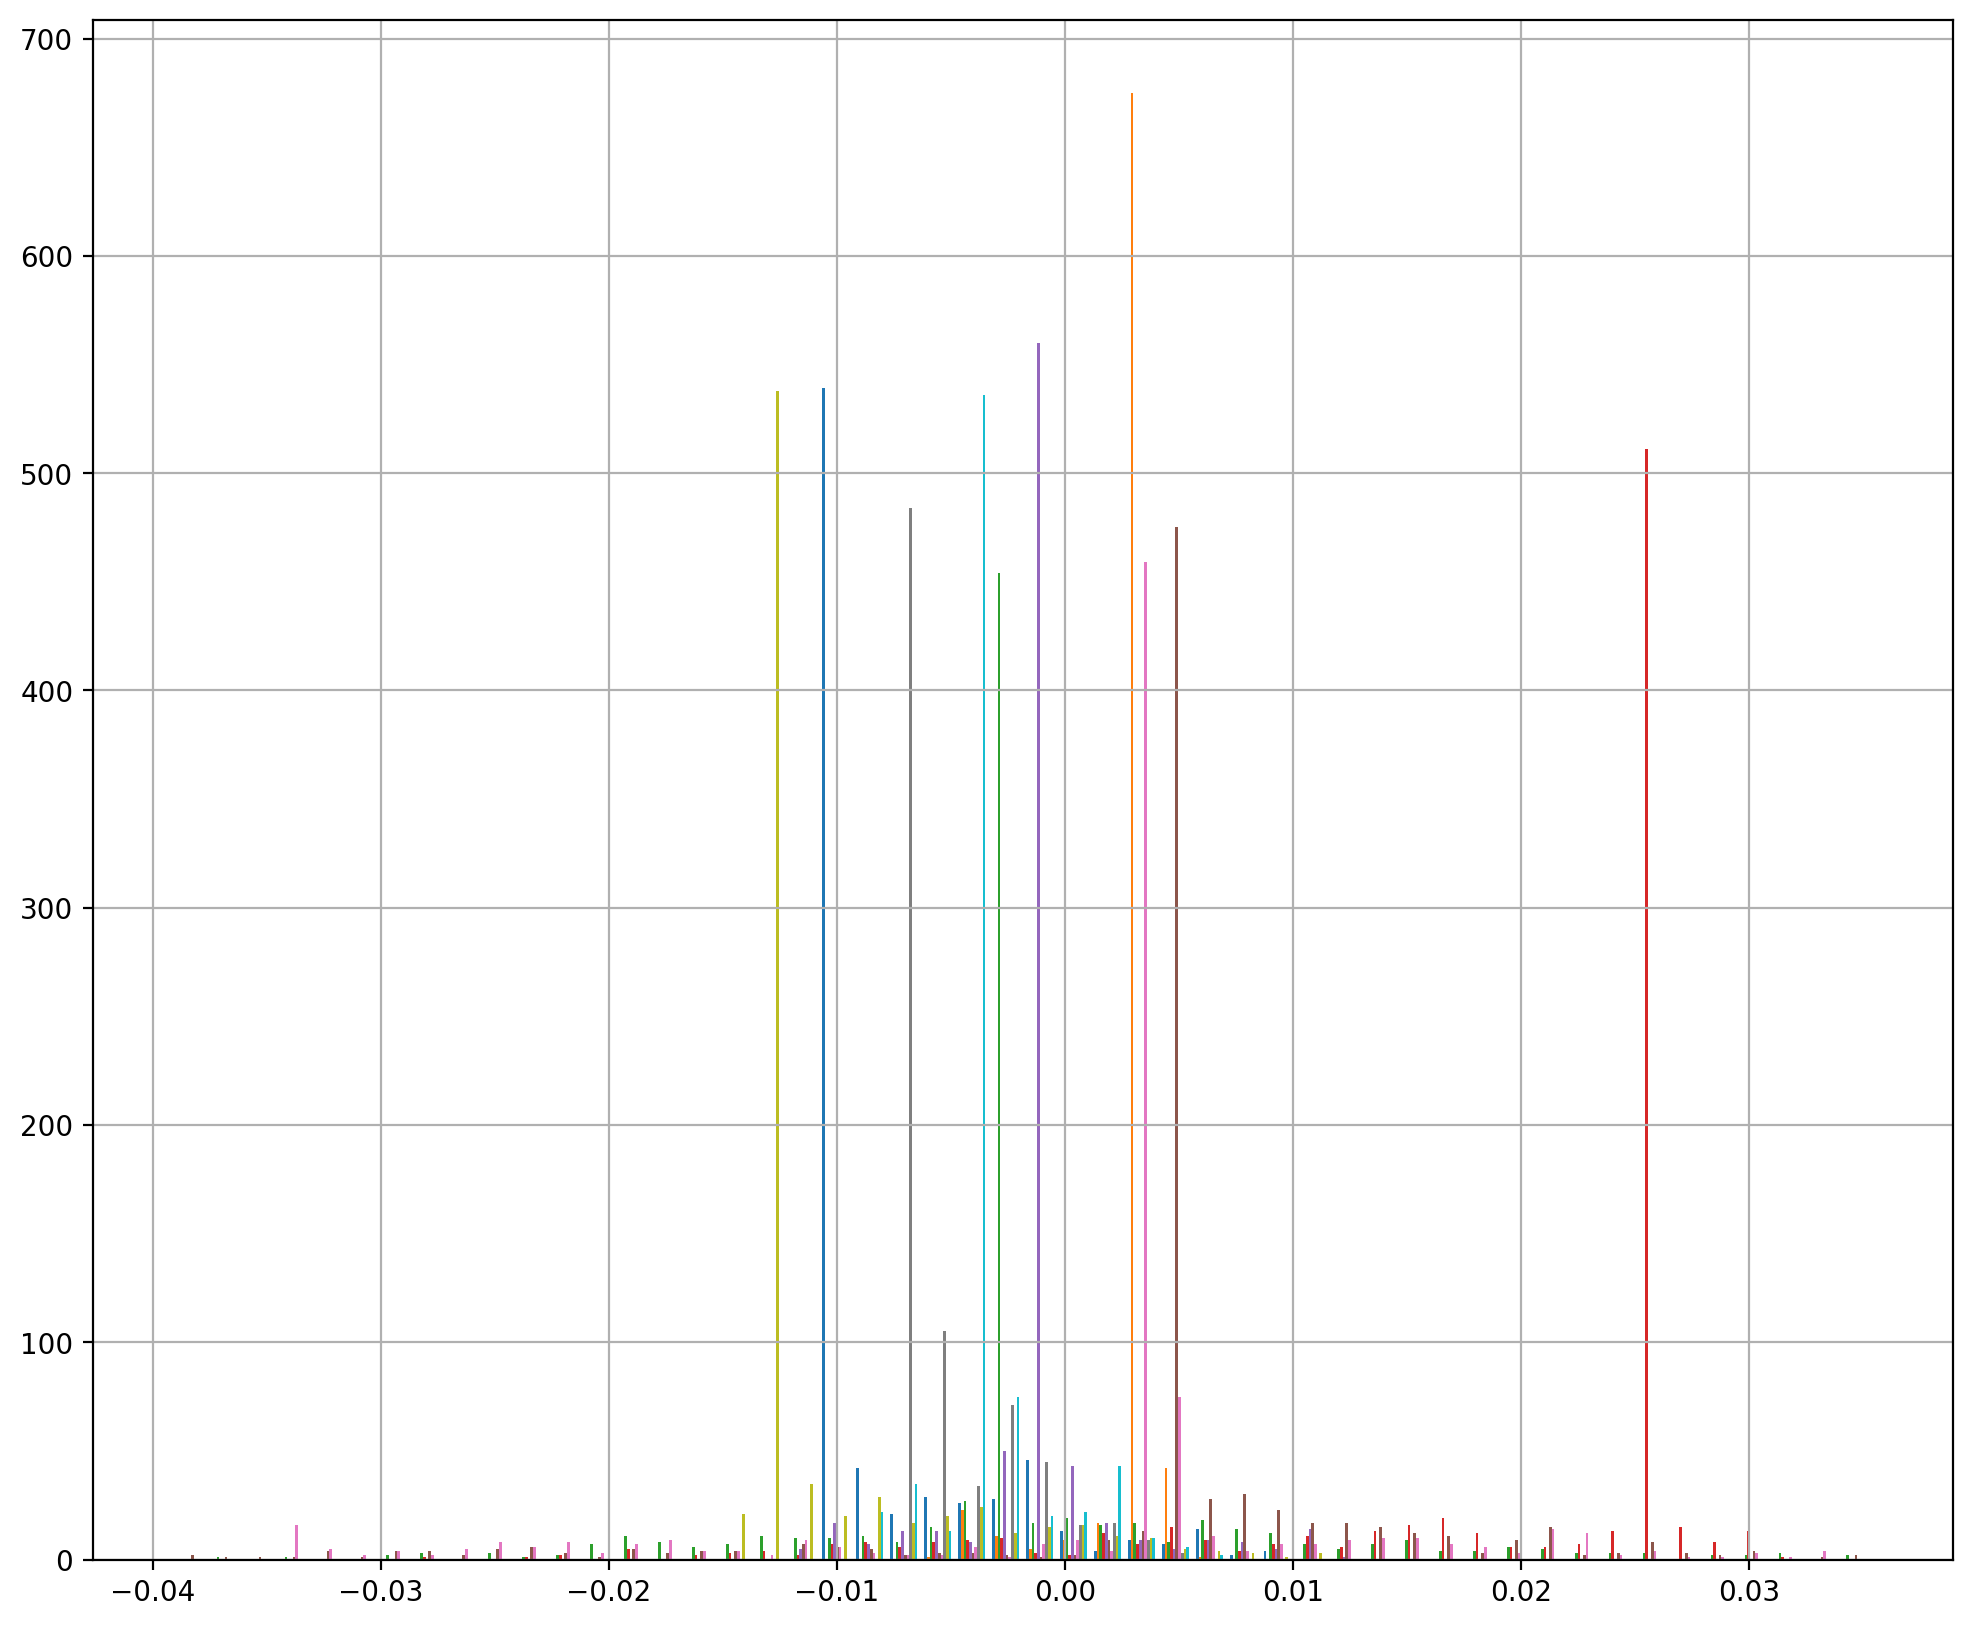

In [20]:
#YOUR CODE HERE

fig, ax = plt.subplots(figsize = (12,10))
ax.hist(my_LR.output.weight.grad,50)
ax.grid()
fig.set_facecolor('white')

As we can see most of the gradients are almost zero

## Part III. Train a MLP to do the same job

Modify the code you have just implemented for a MLP is straightforward. Assume we want to train a MLP with three layers, all using rectified linear units (RELU)s as non-linear activations (except the last layer, that uses a Softmax). The first layer has 128 hidden units and the second 64 of them.

In [21]:
Image(url= "https://pytorch.org/docs/stable/_images/ReLU.png", width=300, height=100)

As with the LR, we create a small class defining the model and then a larger class than inherites from it to incorporate methods to perform both training and model evaluation.

> **Exercise**: Complete the code for the following class

In [22]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x) # A la salida se le aplica la logsoftmax para la clasificación multiclase
        return x

> **Excercise** Create a class `MLP_extended` that incorporates two methods to the former class. One to perform training and one to perform model evaluation. It is just **one line of code** diferent from the code you have done above for the multi-class LR. This is why I like class and structure my code this way!!

In [23]:
#YOUR CODE HERE

class MLP_extended(MLP):

    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
        
    def accuracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in loader:
        
                logprobs = modelo.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        

        return ((accuracy/len(loader)))

Train the model for 10 epochs and compute the train/test performance. Then plot the loss during trianing. How does it compare with the Logistic Regressor?

In [24]:
#YOUR CODE HERE
my_MLP = MLP_extended(dimx=784,hidden1=128,hidden2=64,nlabels=10,epochs=10,lr=1e-3) # Establecemos los nodos que tendrán las capas ocultas
my_MLP.train(trainloader) # Entrenamos el MLP

Training loss after 0 epochs: 0.400052
Training loss after 1 epochs: 0.191528
Training loss after 2 epochs: 0.138806
Training loss after 3 epochs: 0.111422
Training loss after 4 epochs: 0.097899
Training loss after 5 epochs: 0.083995
Training loss after 6 epochs: 0.072885
Training loss after 7 epochs: 0.069510
Training loss after 8 epochs: 0.062301
Training loss after 9 epochs: 0.056041


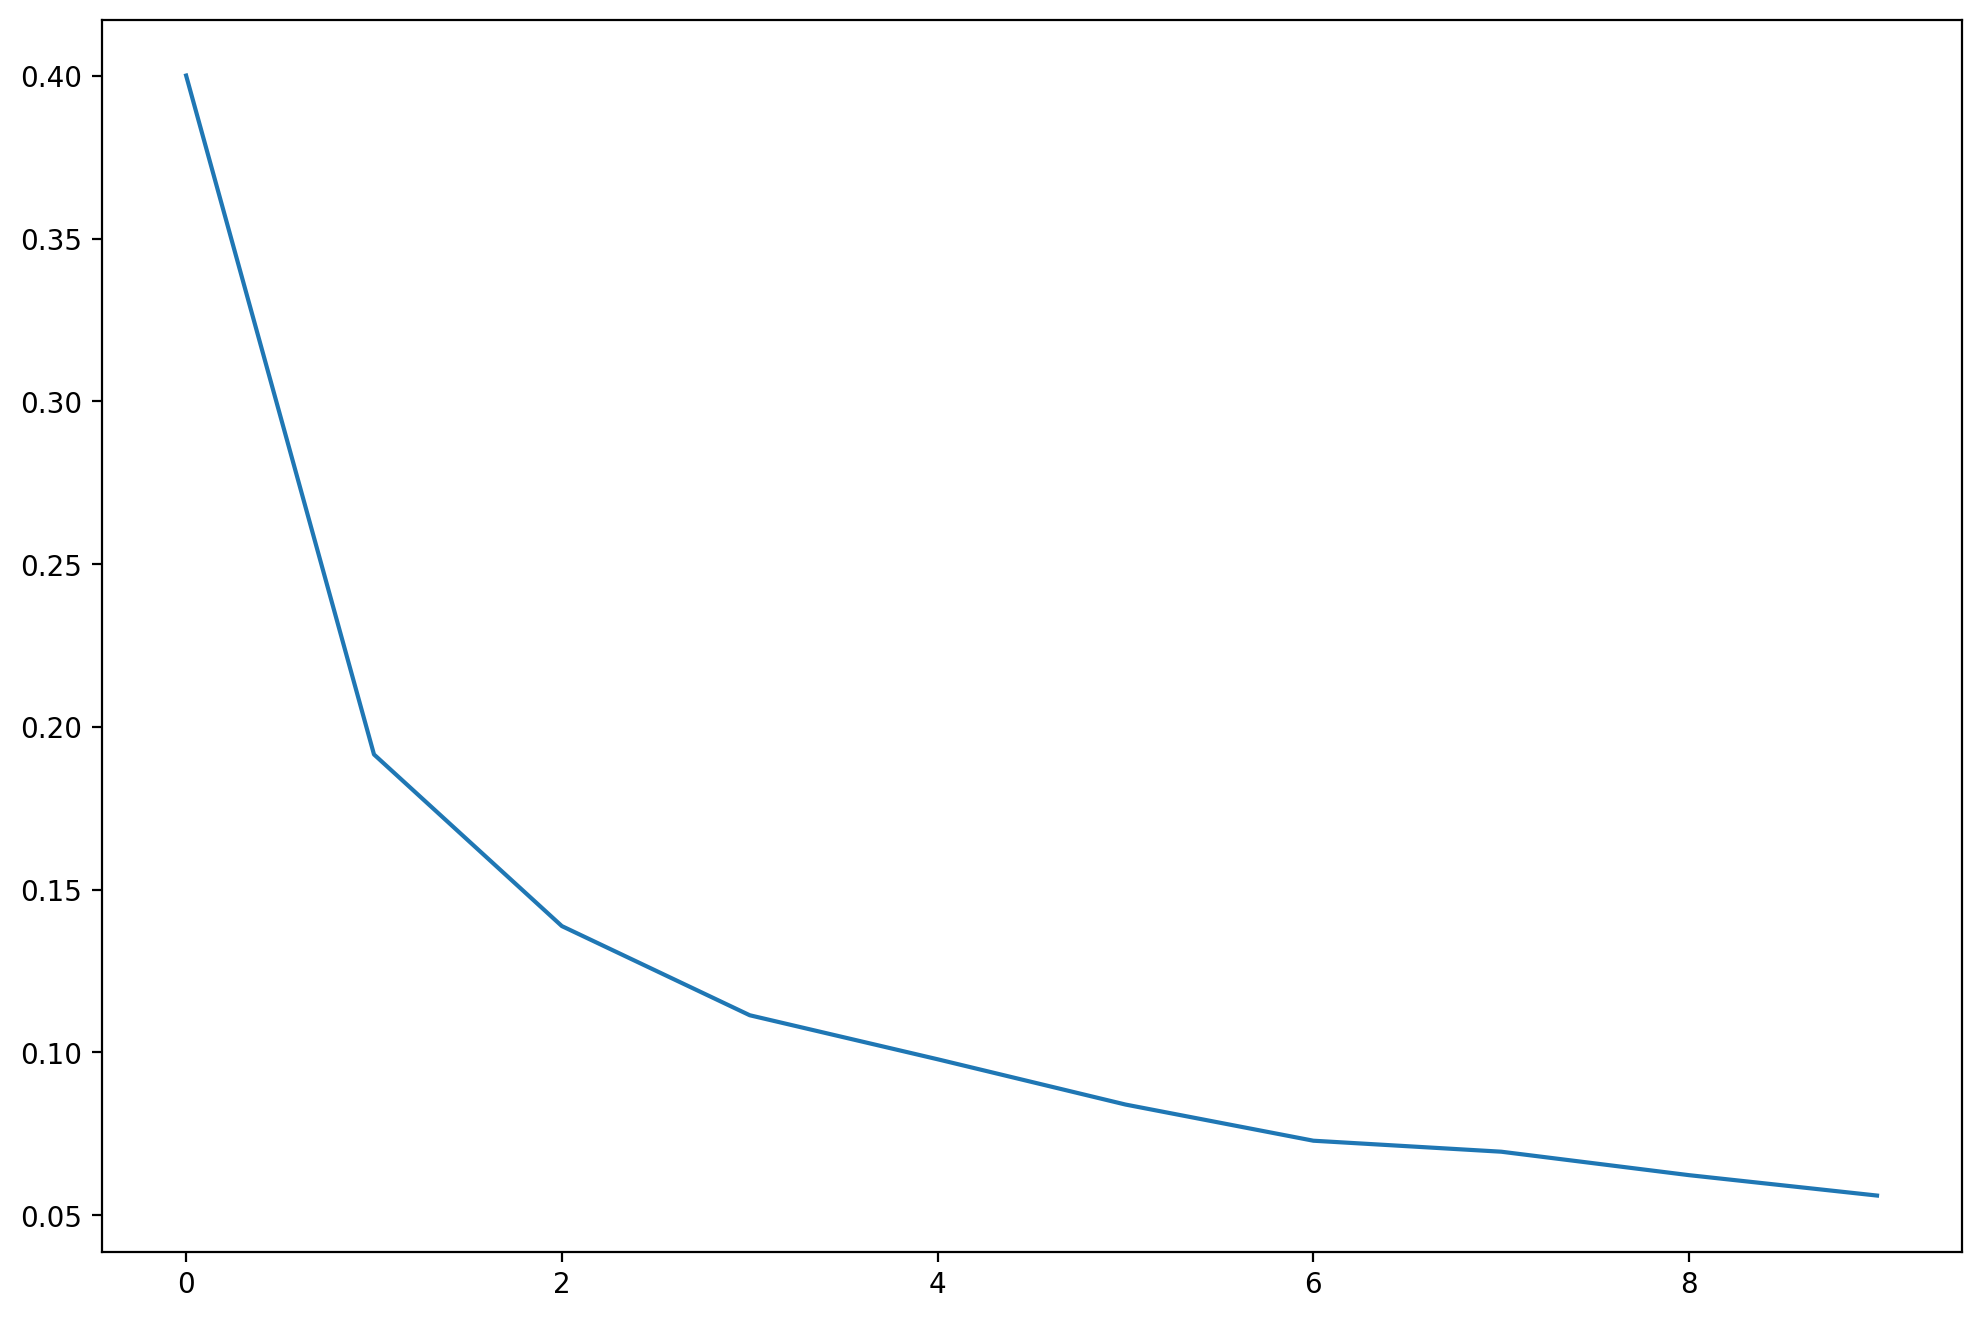

In [25]:
# Vamos a ver la curva de pérdidas

fig , ax = plt.subplots(figsize = (12,8))
ax.plot(my_MLP.loss_during_training)
fig.set_facecolor('white')

Podemos observar que el valor de la función de pérdidas es menor que con el LR multiclase y, además, converge de forma mucho más rápida.

Wow! Performace is almost perfect with a naive Neural Network!!

> **Exercise:** Lets visualize the activations at the ouput of the first layer for a minibatch of test images. This will help to identify possible unused hidden units (always activated/deactivated) and correlated hidden units, e.g. redundant units. Complete the following code.

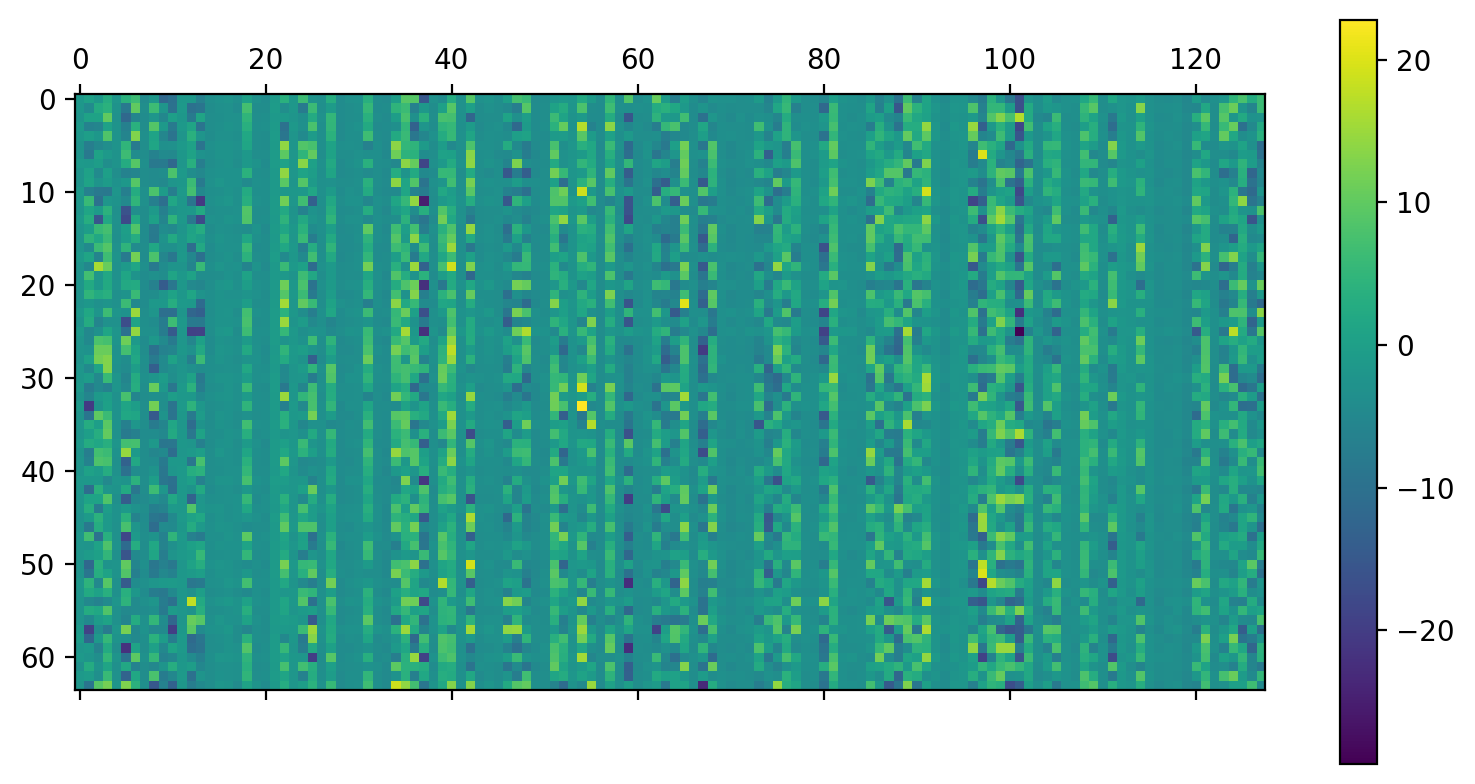

In [27]:
# First, we load a test minibatch

x_test,y_test = next(iter(testloader)) 

# Then, we evaluate the output of the first layer of the network for that mini-batch

activations = my_MLP.output1(x_test.view(x_test.shape[0], -1))

# We plot the matrix using matplotlib

plt.matshow(activations.detach().numpy())

plt.colorbar()


Based on the plot, do you think there are unsued hidden units in the hidden layer? They are characterized by units that are always active (very high values) or unactive (almost zero values). Plot the variance of the hidden units across the test mini-batch to better visualize these unactive hidden units. 

Vemos que hay varias activaciones que tienen un valor cercano a 0. Esto es debido a que estamos usando una estructura demasiado compleja para el problema que estamos resolviendo.

There are 16 hidden units that are unactive


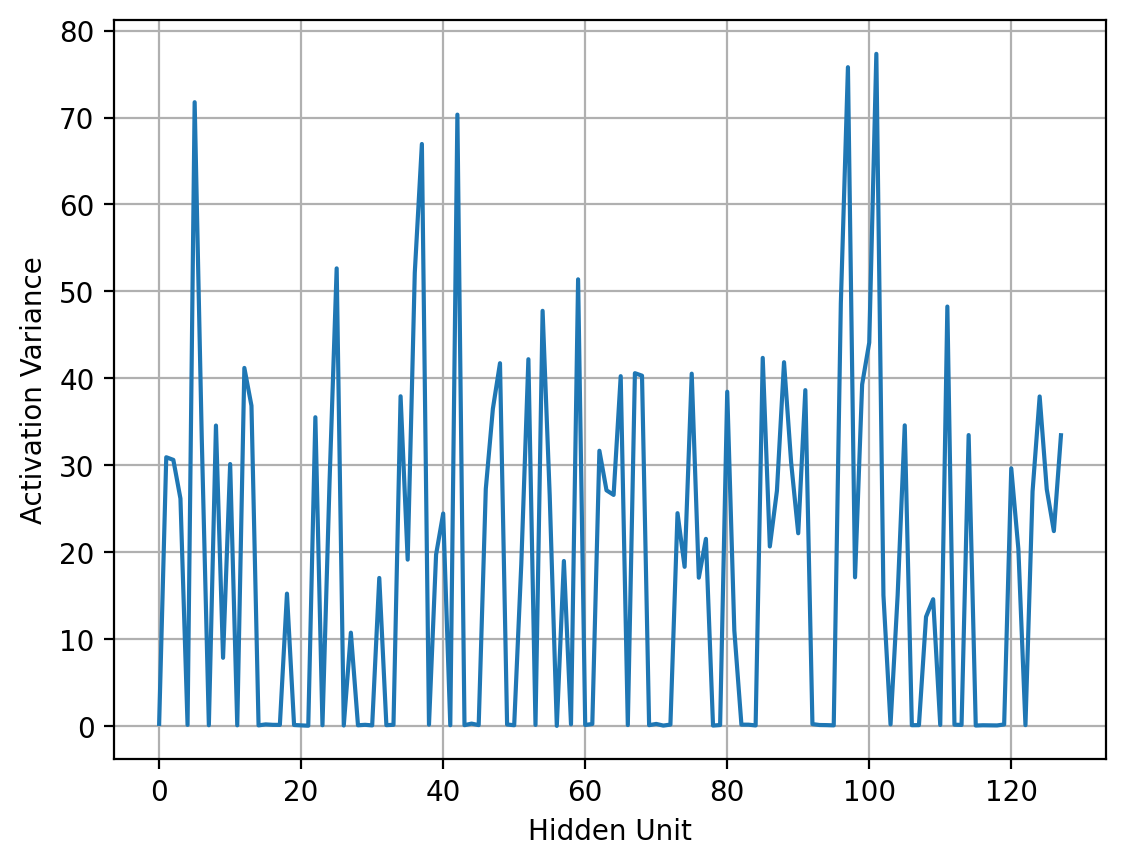

In [32]:
plt.plot(np.var(activations.detach().numpy(),0))
plt.grid()
plt.xlabel('Hidden Unit')
plt.ylabel('Activation Variance')

print("There are {0:d} hidden units that are unactive".format(np.sum(np.var(activations.detach().numpy(),0)<=0.1)))

Tenemos 16 unidades ocultas inactivas por lo mencionado anteriormente. Para resolver esto podemos probar a reducir el número de nodos en las capas ocultas.

> **Exercise**: Retrain the model reducing accordingly the dimension of the first hidden layer. For that model, repeat the analysis to the activations of both the first and the second layer. 
>
>You will notice that in general, unsued activations are prominent in the first layer compared to the second one. This is in general the case for any NN, as the **loss function is more sensitive to parameter variations in the last layers**, and hence gradients are higher in magnitude. On the contrary, the **loss function is less senstive to parameter variations in the first layers** and hence only very relevant parameters are trained (they influence more in the loss function), while many others vary very little w.r.t. initialization.

In [33]:
#YOUR CODE HERE
my_MLP = MLP_extended(dimx=784,hidden1=64,hidden2=32,nlabels=10,epochs=10,lr=1e-3) # Vamos a reducir el número de nodos en las capas ocultas
my_MLP.train(trainloader) # Entrenamos el MLP

Training loss after 0 epochs: 0.484334
Training loss after 1 epochs: 0.260447
Training loss after 2 epochs: 0.195156
Training loss after 3 epochs: 0.159290
Training loss after 4 epochs: 0.139083
Training loss after 5 epochs: 0.122858
Training loss after 6 epochs: 0.111499
Training loss after 7 epochs: 0.102316
Training loss after 8 epochs: 0.094659
Training loss after 9 epochs: 0.089476


In the first layer, there are 5 hidden units that are unactive
In the second layer, there are 0 hidden units that are unactive


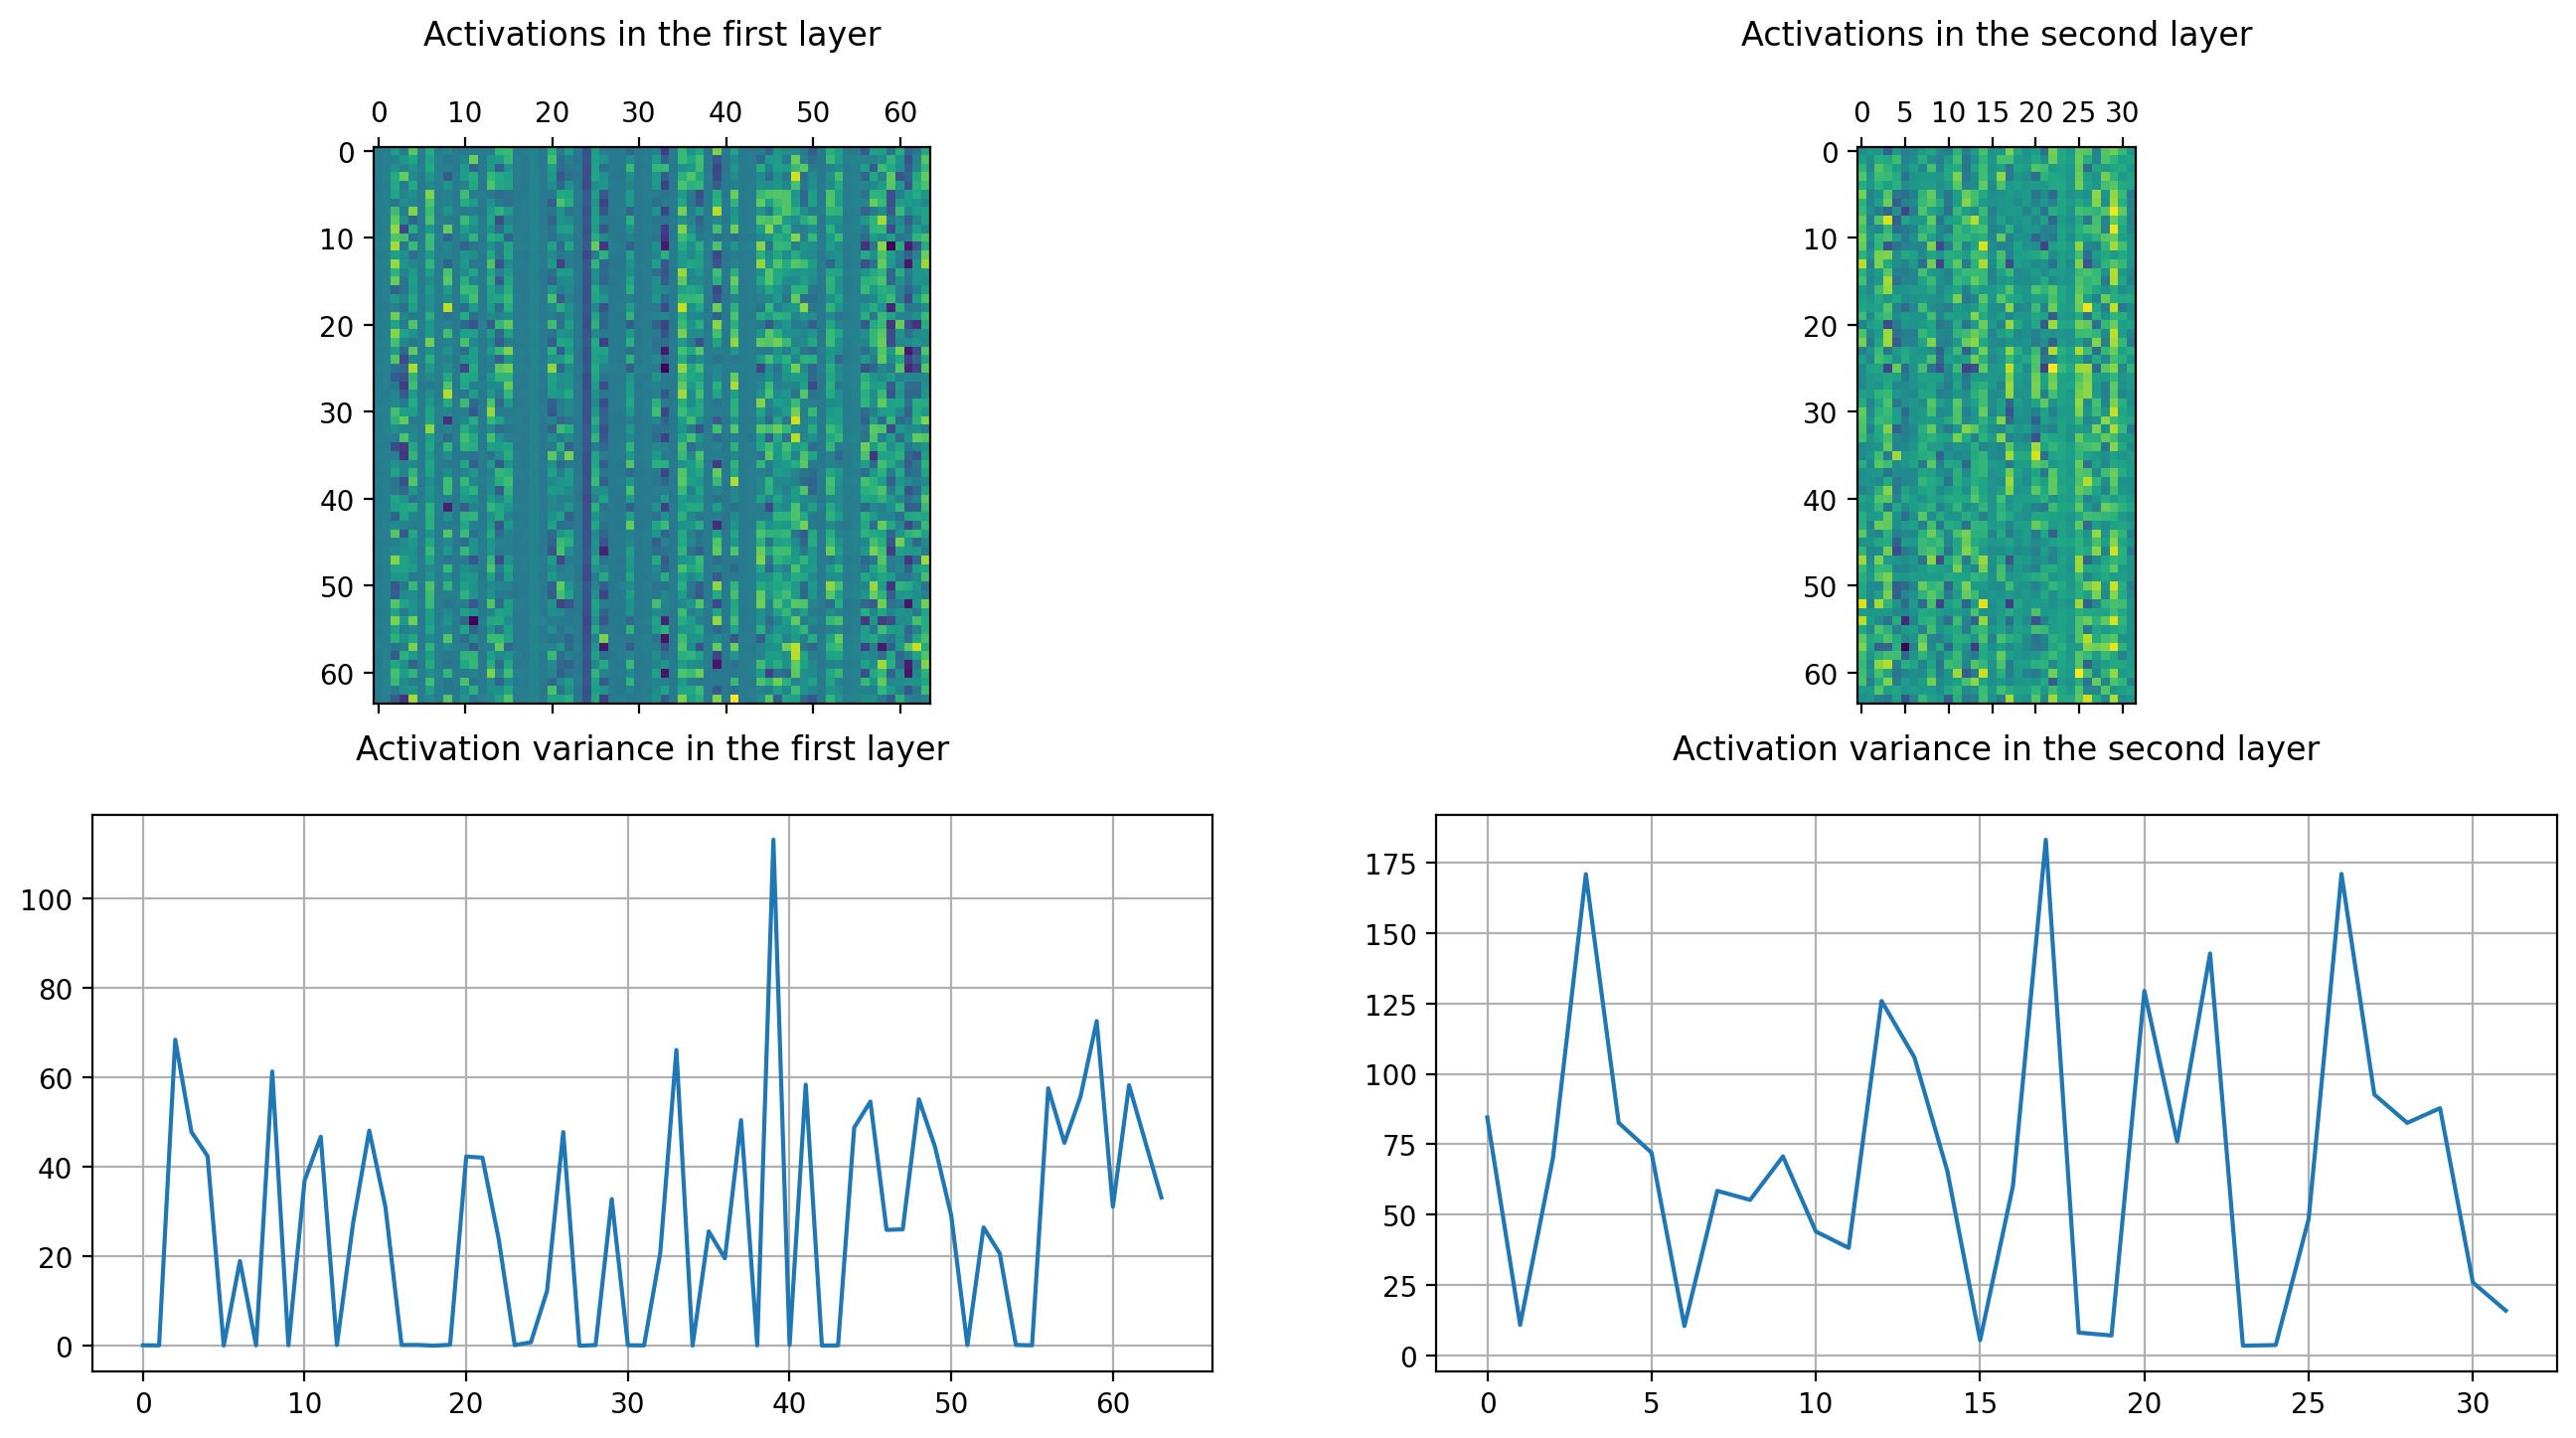

In [36]:
activations_1 = my_MLP.output1(x_test.view(x_test.shape[0], -1))

# Then, we evaluate the output of the first layer of the network for that mini-batch
activations_2 = my_MLP.output2((activations_1.view(activations_1.shape[0], -1)))

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(16, 8))
im = ax[0,0].matshow(activations_1.detach().numpy())
ax[0,0].set_title('Activations in the first layer\n')

ax[0,1].matshow(activations_2.detach().numpy())
ax[0,1].set_title('Activations in the second layer\n')

ax[1,0].plot(np.var(activations_1.detach().numpy(),0))
ax[1,0].set_title('Activation variance in the first layer\n')
ax[1,0].grid()

ax[1,1].plot(np.var(activations_2.detach().numpy(),0))
ax[1,1].set_title('Activation variance in the second layer\n')
ax[1,1].grid()

print("In the first layer, there are {0:d} hidden units that are unactive".format(np.sum(np.var(activations_1.detach().numpy(),0)<=0.1)))

print("In the second layer, there are {0:d} hidden units that are unactive".format(np.sum(np.var(activations_2.detach().numpy(),0)<=0.1)))

Vemos que hemos logrado reducir significativamente el número de unidades inactivas por la reducción del tamaño de la capa.

Por otro lado, contemplamos como no tenemos ninguna unidad inactiva en la segunda capa. En esta segunda es más sensible la variación de parámetros.

De esta manera, comprobamos que ahora contamos con una arquitectura algo más acorde a nuestro problema.

> **Exercise**: Plot the histogram of the gradient of the loss function w.r.t. the parameters in the model for the first and the last layers and compare them.

Text(0.5, 1.0, 'Salida capa 3')

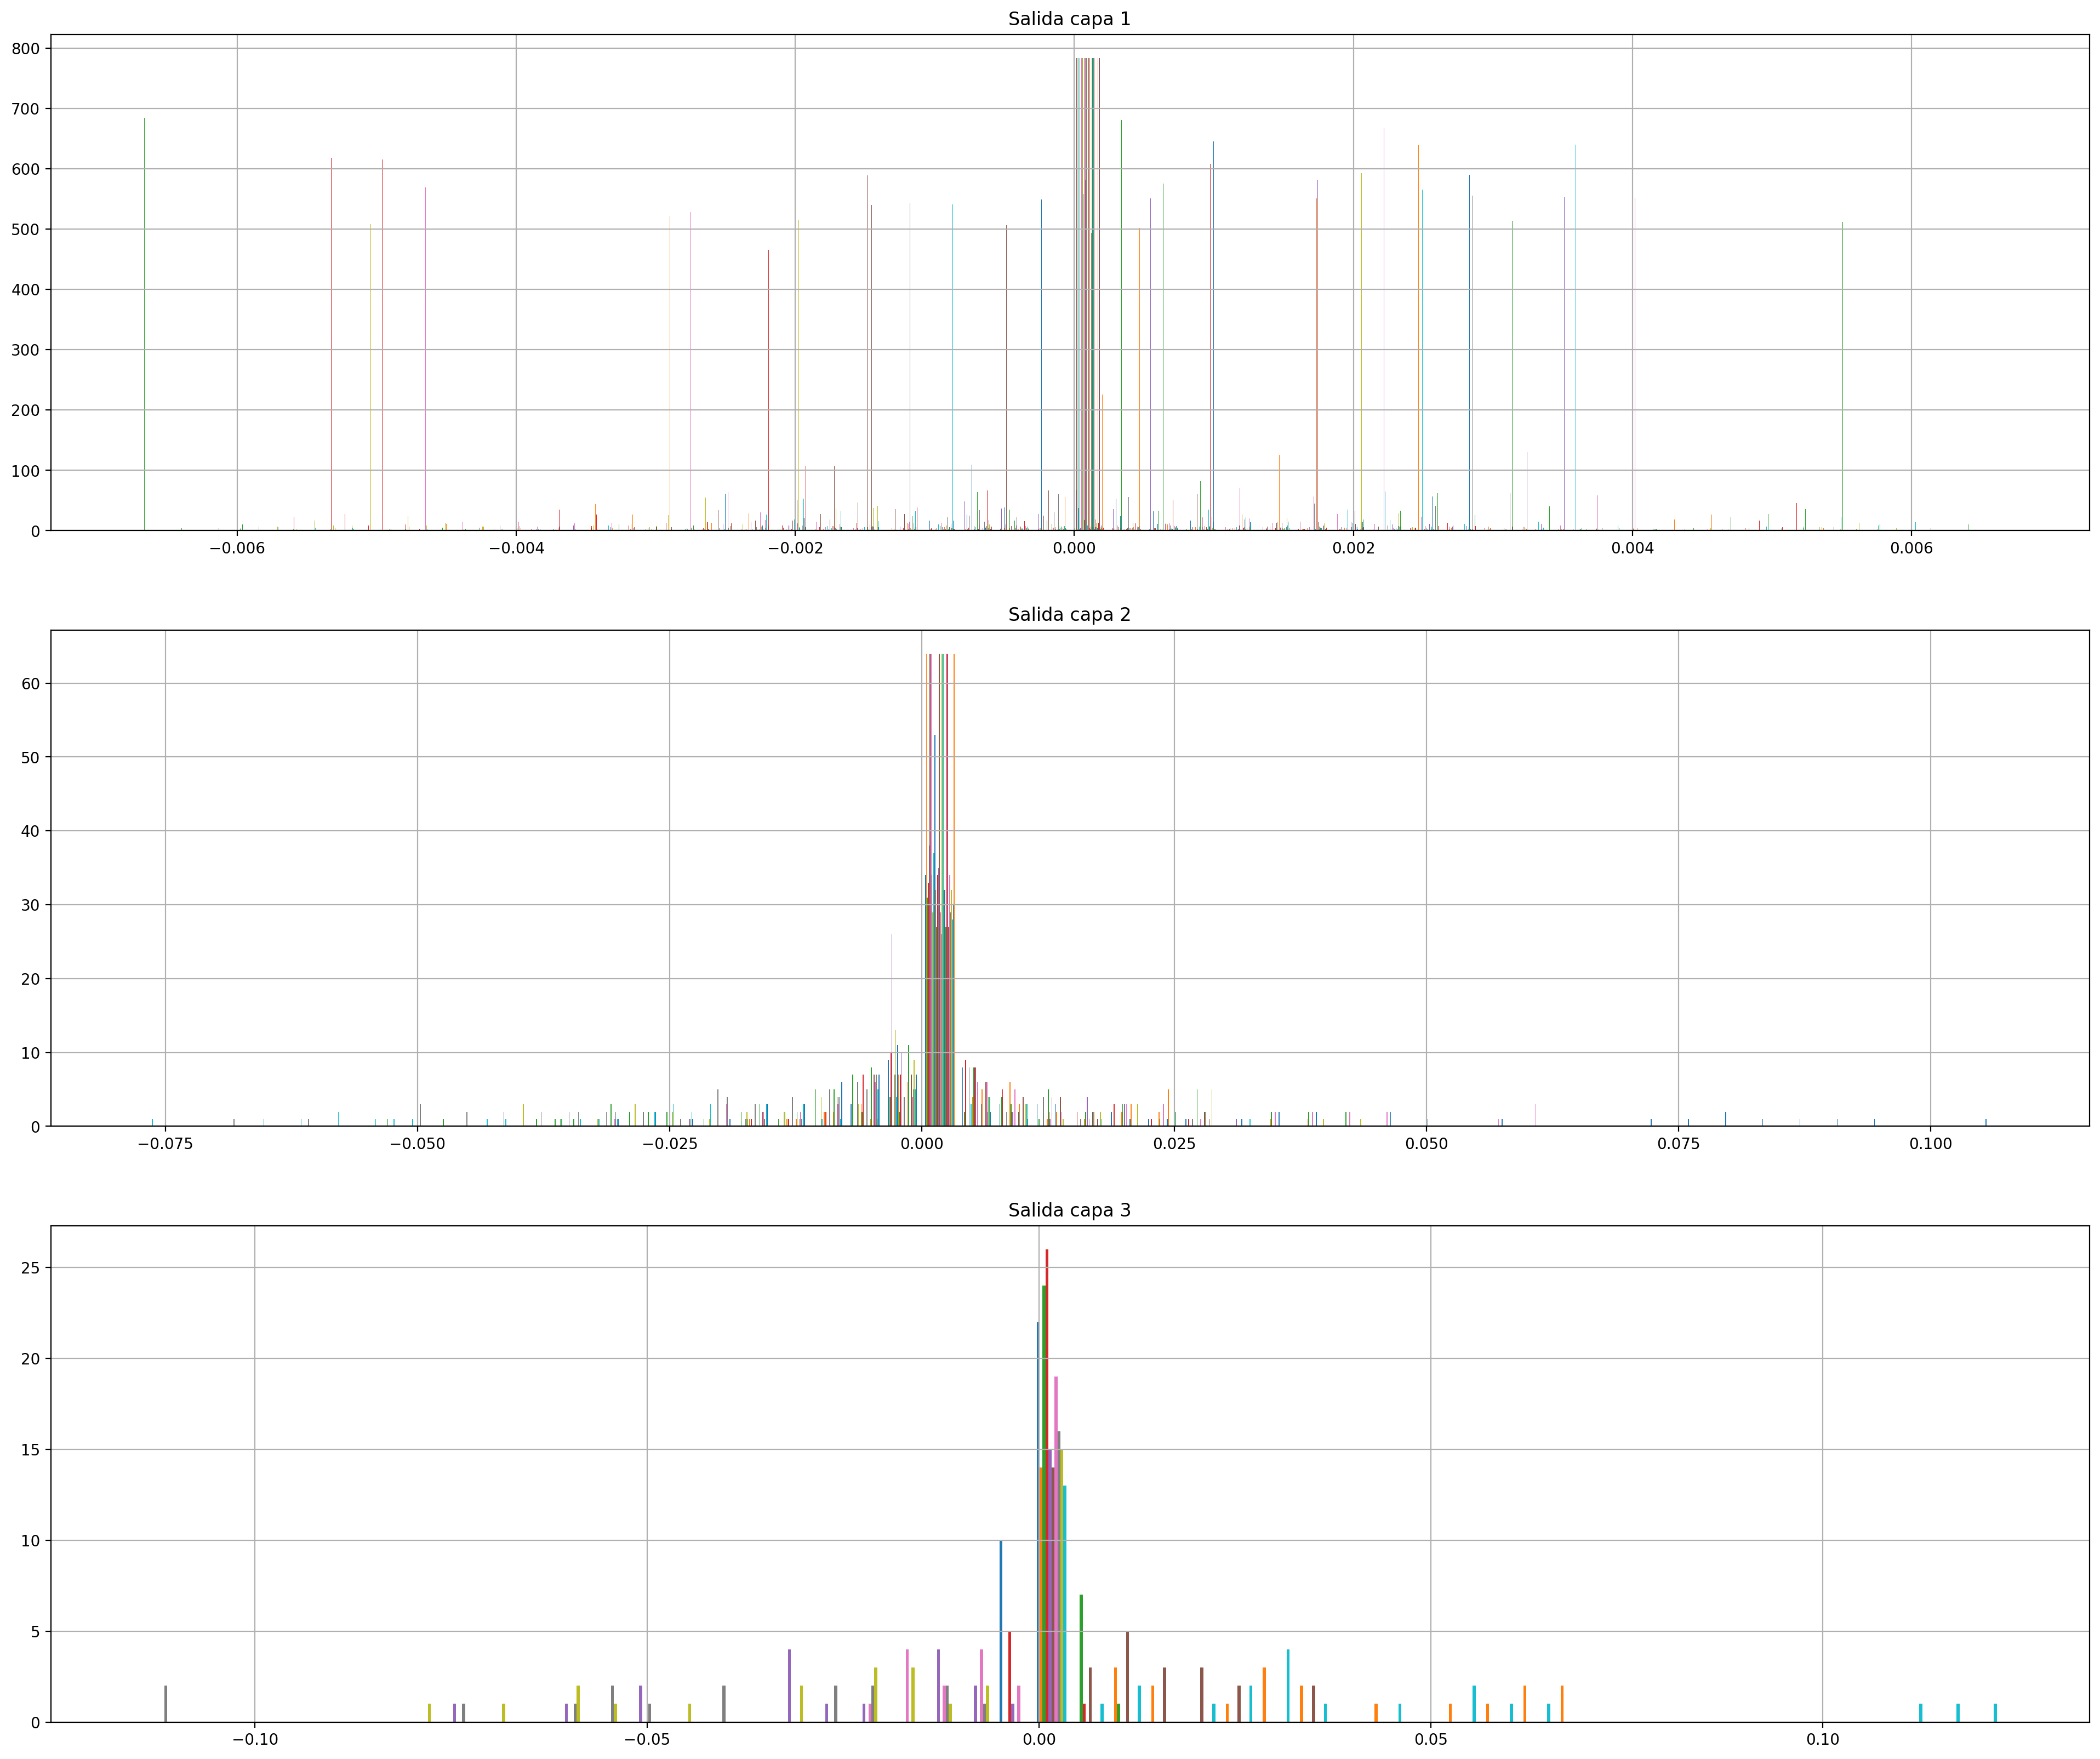

In [37]:
# YOUR CODE HERE

fig, ax = plt.subplots(3, figsize = (24,20))
ax[0].hist(my_MLP.output1.weight.grad,50)
ax[0].grid()
ax[0].set_title('Salida capa 1')
ax[1].hist(my_MLP.output2.weight.grad,50)
ax[1].grid()
ax[1].set_title('Salida capa 2')
ax[2].hist(my_MLP.output3.weight.grad,50)
ax[2].grid()
ax[2].set_title('Salida capa 3')


Como vemos, a medida que avanzamos en las capas, contamos con menos neuronas que no están siendo usadas. Los pesos que tienen un valor alto, corresponde a los píxeles que contienen información relevante, hecho que se focaliza a medida que nos acercamos a la salida final del MLP capa a capa.

### Part IV. Saving and restoring the model

Finally, we will show you how to save and load models (i.e. values of the parameters) with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [38]:
print("Our model: \n\n", my_MLP, '\n')
print("The state dict keys: \n\n", my_MLP.state_dict().keys())

Our model: 

 MLP_extended(
  (output1): Linear(in_features=784, out_features=64, bias=True)
  (output2): Linear(in_features=64, out_features=32, bias=True)
  (output3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
) 

The state dict keys: 

 odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias'])


The simplest thing to do is saving the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [39]:
torch.save(my_MLP.state_dict(), 'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [40]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias'])


And to load the state dict in to the network, you do `my_MLP.load_state_dict(state_dict)`.

In [41]:
my_MLP.load_state_dict(state_dict)

<All keys matched successfully>

**Important:** `load_state_dict` will raise an error if the architecture of the network is different from the one saved in the pth file. For example, if we define the following model.

In [42]:
my_MLP2 = MLP_extended(dimx=784,hidden1=256,hidden2=128,nlabels=10,epochs=10,lr=1e-3)

which differs from `my_MLP` in the dimension of the hidden layers, we will get an error if we call the method  `load_state_dict(state_dict)`.

> **Exercise:** Check that you get an error when trying to initialize my_MLP2 from `state_dict` using the method `load_state_dict`

In [43]:
my_MLP2.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for MLP_extended:
	size mismatch for output1.weight: copying a param with shape torch.Size([64, 784]) from checkpoint, the shape in current model is torch.Size([256, 784]).
	size mismatch for output1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output2.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for output2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for output3.weight: copying a param with shape torch.Size([10, 32]) from checkpoint, the shape in current model is torch.Size([10, 128]).